In [ ]:
pip install hmmlearn yfinance numpy pandas scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.1/161.1 kB 5.5 MB/s eta 0:00:00


[*********************100%%**********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - loss: 0.0530 - val_loss: 0.0740
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0625 - val_loss: 0.0734
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0618 - val_loss: 0.0742
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0613 - val_loss: 0.0759
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0613 - val_loss: 0.0781
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0532 - val_loss: 0.0799
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 0.0567 - val_loss: 0.0806
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0554 - val_loss: 0.0797
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0622 - val_loss: 0.0805
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0628 - val_loss: 0.0812
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0605 - val_loss: 0.0812
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0

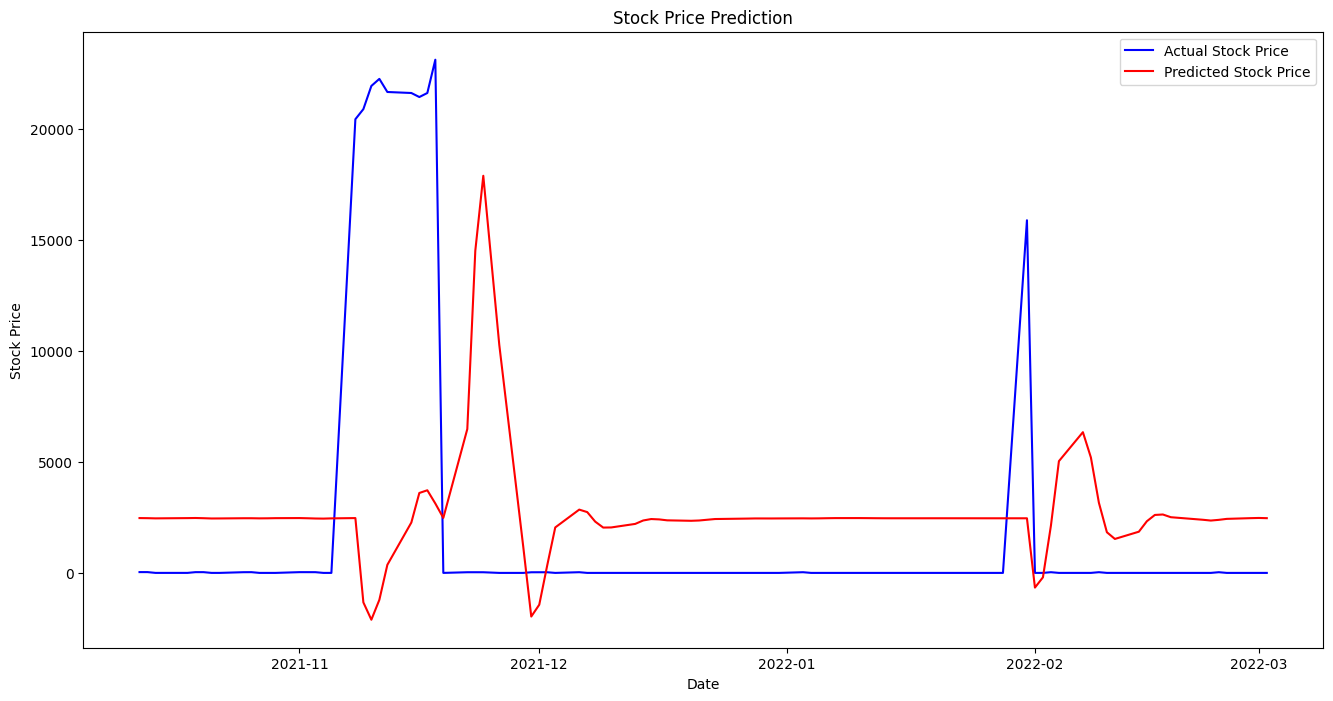

In [ ]:
 # Predicting Stock Price using a HMM and LSTM Model

import numpy as np
import pandas as pd
import yfinance as yf
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# Downloading historical stock data
def get_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    stock_data = stock_data[['Open', 'High', 'Low', 'Close', 'Volume']]
    return stock_data

# Using Feature Engineering
def compute_features(data):
    data['Open-Close'] = data['Open'] - data['Close']
    data['High-Low'] = data['High'] - data['Low']
    data['Return'] = data['Close'].pct_change()
    data['LogReturn'] = np.log(data['Close'] / data['Close'].shift(1))
    data = data.dropna()
    return data[['Open-Close', 'High-Low', 'Return', 'LogReturn']]

# Training Hidden Markov Model
def train_hmm(X_train, n_components=4):
    model = GaussianHMM(n_components=n_components, covariance_type="diag", n_iter=1000)
    model.fit(X_train)
    return model

# Preparing LSTM Model Input
def prepare_lstm_input(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# Building LSTM Model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=25))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Loading Data
ticker = 'ITC'
start_date = '2020-01-01'
end_date = '2023-01-01'
stock_data = get_stock_data(ticker, start_date, end_date)

# Using Feature Engineering
X = compute_features(stock_data)

# Spliting the data into train and test sets
X_train, X_test = train_test_split(X, test_size=0.3, shuffle=False)

# Training HMM Model
hmm_model = train_hmm(X_train)

# Predicting hidden states for the entire dataset
hidden_states = hmm_model.predict(X)

# Adding hidden states to the feature set
X['Hidden State'] = hidden_states

# Preparing LSTM data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(stock_data['Close'].values.reshape(-1, 1))

window_size = 60
X_lstm, y_lstm = prepare_lstm_input(scaled_data, window_size)

# Spliting data into train and test sets for LSTM
train_size = int(len(X_lstm) * 0.8)
X_lstm_train, y_lstm_train = X_lstm[:train_size], y_lstm[:train_size]
X_lstm_test, y_lstm_test = X_lstm[train_size:], y_lstm[train_size:]

# Building and training LSTM model
lstm_model = build_lstm_model((X_lstm_train.shape[1], X_lstm_train.shape[2]))
lstm_model.fit(X_lstm_train, y_lstm_train, batch_size=32, epochs=50, validation_data=(X_lstm_test, y_lstm_test))

# Predicting stock prices using the LSTM model
predicted_stock_price = lstm_model.predict(X_lstm_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

# Plotting the results
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.plot(stock_data['Close'].iloc[-len(predicted_stock_price):].index, scaler.inverse_transform(y_lstm_test.reshape(-1, 1)), color='blue', label='Actual Stock Price')
plt.plot(stock_data['Close'].iloc[-len(predicted_stock_price):].index, predicted_stock_price, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
